## 네이버 영화 리뷰 데이터를 통한 감성 분석(NSMC 데이터셋) 

- LSTM은 순환 신경망의 한 종류
- 시계열 데이터 모델임


In [16]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request

from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [17]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")
# 깃허브에서 데이터 불러옴

('ratings_test.txt', <http.client.HTTPMessage at 0x274d3657c80>)

In [18]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
#pandas를 이용하여 훈련 데이터, 테스트 데이터를 나누어 저장함

In [19]:
print("훈련용 리뷰 개수: ", len(train_data)) #훈련용 리뷰 개수 출력

훈련용 리뷰 개수:  150000


In [20]:
train_data[5:10]
# 훈련 데이터가 어떻게 생겼는지 확인함 
# id는 감성 분류에 도움이 되지 않으므로 무시함

,id,document,label
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [21]:
print("테스트용 리뷰 개수:", len(test_data)) #테스트용 리뷰 개수 출력

테스트용 리뷰 개수: 50000


In [22]:
test_data[5:10]

,id,document,label
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1


In [23]:
# train_data의 데이터 중복 유무를 확인한다.
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [24]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)


In [25]:
print('총 샘플의 수 :',len(train_data))


총 샘플의 수 : 146183


<Axes: xlabel='label'>

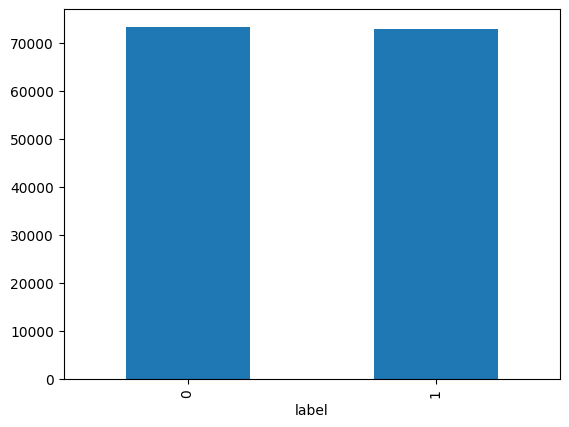

In [26]:
train_data['label'].value_counts().plot(kind = 'bar')
#리뷰의 긍, 부정 유무가 기재되어 있는 label 값의 분포

In [27]:
print(train_data.groupby('label').size().reset_index(name = 'count'))
#긍정, 부정 리뷰의 개수가 정확히 몇 개인지 확인

   label  count
0      0  73342
1      1  72841


In [28]:
#리뷰 중에 null 값이 있는지 확인
print(train_data.isnull().values.any())


True


In [29]:
print(train_data.isnull().sum())
#어떤 열에 null 값이 있는지 확인

id          0
document    1
label       0
dtype: int64


In [30]:
train_data.loc[train_data.document.isnull()]
#어느 인덱스의 위치에 존재하는지 확인

,id,document,label
25857,2172111,NaN,1


In [31]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인


False


In [32]:
print(len(train_data)) #제거 후 데이터 개수 확인

146182


In [33]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))


do you expect people to read the FAQ etc and actually accept hard atheism


In [34]:
#위 원리를 한글에 적용
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[5:10]


,id,document,label
5,5403919,막 걸음마 뗀 세부터 초등학교 학년생인 살용영화ㅋㅋㅋ별반개도 아까움,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지정말 발로해도 그것보단 낫...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데 꽤 볼만한데 헐리우드식 화려함에만 너무 길들여져 있나,1


In [35]:
#만약 한글이 아닌 글자가 포함되어 있다면 공백으로 되어 있기에 다시 조회
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())


id            0
document    789
label         0
dtype: int64


C:\Users\shy03\AppData\Local\Temp\ipykernel_23884\1114045172.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [36]:
train_data.loc[train_data.document.isnull()][:5]
# null 값이 있는지 확인

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [37]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))
#null 데이터 제거

145393


In [38]:
# 테스트 데이터에도 같은 작업을 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))


전처리 후 테스트용 샘플의 개수 : 48852


C:\Users\shy03\AppData\Local\Temp\ipykernel_23884\872982143.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


In [39]:
#토큰화 진행 - 불용어 제거 기본보다 좀 더 추가함
stopwords = [
    '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
    '그','수','것','되다','있다','이다','에서','부터','까지','에게','때문','처럼','더','또','거나','하지만',
    '그리고','그러나','그래도','만약','만큼','하여','해서','그러므로','하지만','때문에','위해',
    '요','네','음','요즘','정말','너무','많이','이제','항상','그냥','오늘','내일','계속','다시',
    '좀','같이','자신','누구','뭐','왜','어디','어떻게','무엇','모두','모든','아직','그런','이런','저런'
]



In [40]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)
# stem = True : 어간 추출
# stem = False : 원형 보존
# 형태소 분석기 Okt를 이용하여 토큰화 진행

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [41]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

#불용어 제거하여 X_train에 저장

  0%|          | 0/145393 [00:00<?, ?it/s]

100%|██████████| 145393/145393 [14:02<00:00, 172.48it/s]


In [42]:
print(X_train[3:8])
#불용어 제거한 결과 확인

[['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'], ['사이', '몬페', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다'], ['막', '걸음', '마', '떼다', '세', '초등학교', '학년', '생인', '살다', '영화', 'ㅋㅋㅋ', '별', '반개', '아깝다', '움'], ['원작', '긴장감', '을', '제대로', '살리다'], ['별', '반개', '아깝다', '욕', '나오다', '이응경', '길용우', '연', '기', '생활', '몇', '년', '인지', '발', '로', '해도', '그것', '보단', '낫다', '납치', '감금', '만', '반복', '반복', '드라마', '가족', '없다', '연기', '못', '사람', '만', '모', '엿']]


In [43]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)
#불용어 제거하여 X_test에 저장

100%|██████████| 48852/48852 [05:32<00:00, 146.78it/s]


In [44]:
# 정수 인코딩 단어 집합을 만듦
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)


In [45]:
print(tokenizer.word_index)


{'영화': 1, '보다': 2, '을': 3, '없다': 4, '좋다': 5, '다': 6, '재밌다': 7, '적': 8, '만': 9, '같다': 10, '진짜': 11, '로': 12, '아니다': 13, '않다': 14, '점': 15, '만들다': 16, '나오다': 17, '연기': 18, '평점': 19, '내': 20, '최고': 21, '나': 22, '안': 23, '인': 24, '스토리': 25, '생각': 26, '못': 27, '드라마': 28, '게': 29, '감동': 30, '사람': 31, '보고': 32, '이렇다': 33, '말': 34, '고': 35, '아깝다': 36, '배우': 37, '때': 38, 'ㅋㅋ': 39, '아': 40, '감독': 41, '거': 42, '재미있다': 43, '재미': 44, '시간': 45, '내용': 46, '중': 47, '주다': 48, '자다': 49, '하고': 50, '지루하다': 51, '재미없다': 52, '쓰레기': 53, '모르다': 54, '가다': 55, '들다': 56, '그렇다': 57, '싶다': 58, '지': 59, '작품': 60, '사랑': 61, '알다': 62, '하나': 63, '마지막': 64, '볼': 65, '이건': 66, '정도': 67, '저': 68, '완전': 69, '오다': 70, 'ㅋ': 71, 'ㅠㅠ': 72, '많다': 73, '처음': 74, 'ㅋㅋㅋ': 75, '장면': 76, '액션': 77, '주인공': 78, '이렇게': 79, '안되다': 80, '걸': 81, '차다': 82, '나다': 83, '개': 84, '하': 85, '최악': 86, '돈': 87, '이야기': 88, '지금': 89, '넘다': 90, '느낌': 91, '임': 92, '연출': 93, 'ㅡㅡ': 94, '라': 95, '인데': 96, '듯': 97, '끝': 98, '명작': 99, '좋아하다': 100, '년': 101, '별

In [46]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 43702
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.688526840876854
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.0470081583559385


In [47]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)


단어 집합의 크기 : 19366


In [48]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [49]:
print(X_train[:3])


[[40, 417, 11, 231, 616], [887, 420, 32, 560, 1, 190, 1403, 18, 915, 632, 14], [351, 2395, 2266, 5622, 2, 198, 6]]


In [50]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
# 훈련 데이터와 테스트 데이터의 레이블을 numpy array로 변환

In [51]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
# 빈도수가 낮은 단어가 삭제된다면 빈도수가 낮은 단어만으로 구성되었던 샘플들이 null값이 되었을 수 있기 때문에 다시 점검

In [52]:
# 빈 샘플들을 제거
X_train = [x for i, x in enumerate(X_train) if i not in drop_train]
y_train = [y for i, y in enumerate(y_train) if i not in drop_train]

print(len(X_train))
print(len(y_train))


145077
145077


리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 9.874004838809736


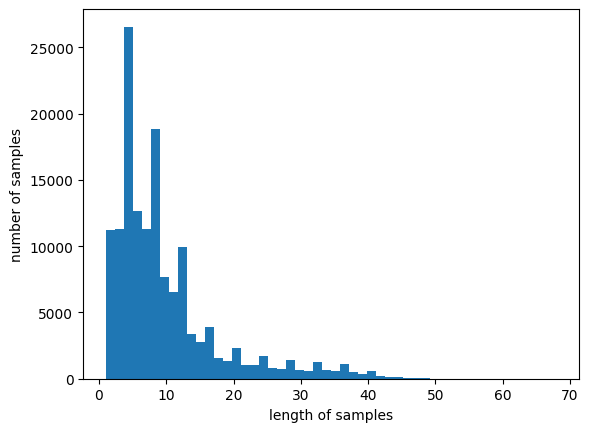

In [53]:
#서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [54]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [55]:
max_len = 30
below_threshold_len(max_len, X_train)


전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.61336393777098


In [56]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

#30 길이로 패딩 작업을 진행

In [57]:
print(type(X_train))
print(type(y_train))
print(len(X_train))
print(X_train[:2])


<class 'numpy.ndarray'>
<class 'list'>
145077
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   40  417   11
   231  616]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  887  420   32  560    1  190 1403   18  915
   632   14]]


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# 1. y_train 정제
y_train = np.array(y_train)

# 2. 모델 구성
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# 3. 콜백 설정
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# 4. 컴파일 & 학습
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, mc]
)


Epoch 1/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7578 - loss: 0.4797
Epoch 1: val_accuracy improved from -inf to 0.83495, saving model to best_model.h5


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 161s 85ms/step - accuracy: 0.7578 - loss: 0.4797 - val_accuracy: 0.8350 - val_loss: 0.3741
Epoch 2/15
1813/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8463 - loss: 0.3523
Epoch 2: val_accuracy improved from 0.83495 to 0.84061, saving model to best_model.h5


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 165s 91ms/step - accuracy: 0.8463 - loss: 0.3522 - val_accuracy: 0.8406 - val_loss: 0.3609
Epoch 3/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.8613 - loss: 0.3259
Epoch 3: val_accuracy improved from 0.84061 to 0.84660, saving model to best_model.h5


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 223s 123ms/step - accuracy: 0.8613 - loss: 0.3259 - val_accuracy: 0.8466 - val_loss: 0.3505
Epoch 4/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8729 - loss: 0.3056
Epoch 4: val_accuracy improved from 0.84660 to 0.84695, saving model to best_model.h5


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 161s 89ms/step - accuracy: 0.8729 - loss: 0.3056 - val_accuracy: 0.8469 - val_loss: 0.3506
Epoch 5/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8875 - loss: 0.2772
Epoch 5: val_accuracy improved from 0.84695 to 0.85153, saving model to best_model.h5


1814/1814 ━━━━━━━━━━━━━━━━━━━━ 166s 92ms/step - accuracy: 0.8875 - loss: 0.2772 - val_accuracy: 0.8515 - val_loss: 0.3473
Epoch 6/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.8959 - loss: 0.2624
Epoch 6: val_accuracy did not improve from 0.85153
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 175s 97ms/step - accuracy: 0.8959 - loss: 0.2624 - val_accuracy: 0.8457 - val_loss: 0.3593
Epoch 7/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9059 - loss: 0.2412
Epoch 7: val_accuracy did not improve from 0.85153
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 202s 111ms/step - accuracy: 0.9059 - loss: 0.2412 - val_accuracy: 0.8475 - val_loss: 0.3555
Epoch 8/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9150 - loss: 0.2237
Epoch 8: val_accuracy did not improve from 0.85153
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 176s 97ms/step - accuracy: 0.9150 - loss: 0.2237 - val_accuracy: 0.8477 - val_loss: 0.3701
Epoch 9/15
1814/1814 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9210 - loss: 0.2096
E

In [59]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
# 모델 평가

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.8519 - loss: 0.3485

 테스트 정확도: 0.8482


In [60]:
with open('tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# 모델 저장

In [61]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))


In [78]:
sentiment_predict('1편에 비해 다소 미흡함')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
70.45% 확률로 부정 리뷰입니다.



C:\Users\shy03\AppData\Local\Temp\ipykernel_23884\2334245811.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new)) # 예측
